# Webscraping Part II

In [1]:
# import packages 
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
from urllib.parse import urljoin
import time


Some CSS selectors to remember:

|      **Selector**     |               **Example**               |                                                                                            **Example description**                                                                                            |
|:---------------------:|:---------------------------------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| element               | p                                       | Selects all `<p>` elements                                                                                                                                                                                    |
| #id                   | #movie-overview                         | The select anything like `<div id="movie-overview">`                                                                                                                                                          |
| .class                | .media-scorecard<br>div.media-scorecard | First example selects all elements with class="media-scorecard",<br>Second example selects only div elements with that class: `<div class='media-scorecard'>`                                                 |
| [attribute="value"]   | rt-link[slot="criticsReviews"]          | Selects an element like `<rt-link slot="criticsReviews">`                                                                                                                                                     |
| Descendant combinator | .discovery-tiles .p--small              | This would select any elements with class='p--small' that were nested inside of an element with class='discovery-tiles'.<br><br>Example: `<div class="discovery-tiles"><span class="p--small">...</span></div>`  |

We're interested in scraping data from the review aggregator Rotten Tomatoes.

Our goal here is to write some code to visit each film listed here and extract information like the critic rating (circled in red below) audience rating (circled in blue below), title, plot synopsis, and genre information. As with the previous example, we have the option of either using the SelectorGadget or inspecting the HTML code to extract the information we want. In practice, we'll often need to use a bit of both to get data effectively.



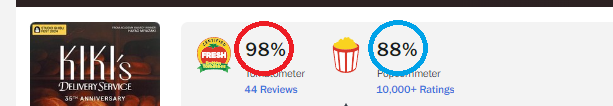

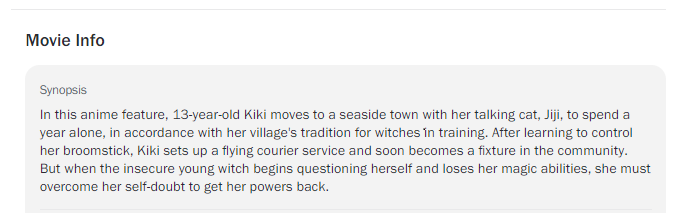

We'll start by collecting a list of links and movie titles. from this url:

https://www.rottentomatoes.com/browse/movies_in_theaters/sort:popular

Remember that we can use a `get` request to download the HTML code for a page into Python, and then we'll want to use `BeautifulSoup` to convert this into a Python object that we can easily navigate

In [115]:
url = 'https://www.rottentomatoes.com/browse/movies_in_theaters/sort:popular'
# get site
site= get(url)
# parse the content
content = BeautifulSoup(site.content, "html.parser")


We want to extract just the link and title from this page, so the element we're interesting in extracting is here:

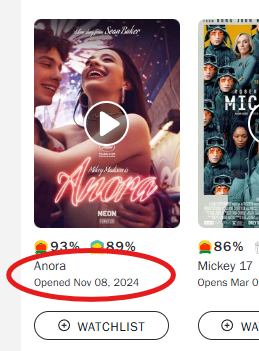

The Selector Gadget gives us an expression that reliably gets the title after a little fiddling:

In [116]:
titles = content.select('.discovery-tiles .p--small')

# checking out the first element
titles[0]


<span class="p--small" data-qa="discovery-media-list-item-title">
          Anora
        </span>

I've got the right elements, now I can just use `get_text()` in a list comprehension to extract the titles (and here again I'll use `strip()` to get rid of some extra whitespace)

In [117]:
title_text = [i.get_text().strip() for i in titles]

title_text[:5]

['Anora',
 'Mickey 17',
 'Last Breath',
 'Captain America: Brave New World',
 'Companion']

Now we want the links to each movie's review page. You can try your luck with the SelectorGadget, but you might find it doesn't work as expected. We'll get a lot of selector expressions that appear to work, but then end up not returning the correct data:

In [118]:
# this returns nothing!
content.select('a span')[0].get('href')

So we'll want to go into the HTML code and search for a better way to extract this element. Remember that you can right-click on an element and go to "inspect" to see the HTML code for it. In this case (using Chrome at least) I get located a span called `p--small`, but what I actually want is the tag highlighted in yellow. So I need to write some code that will extract that element and others like it. 


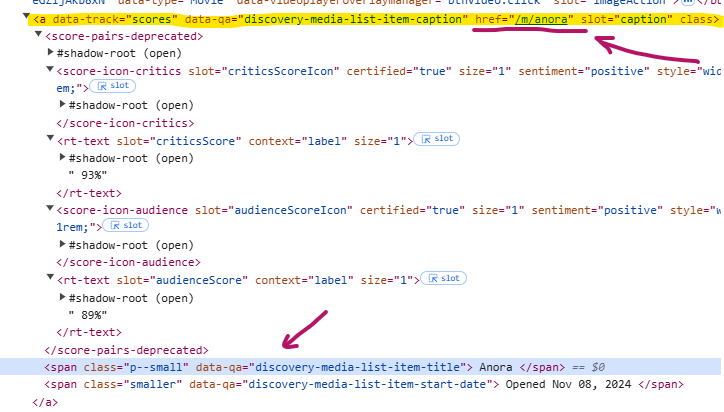

You might want to a look at a couple of other links to make sure, but it appears that `data-track="scores"` is an attribute that shows up in all of the links that I'm interested in extracting. So I'll try out an expression based on this attribute. Remember that the selector expression for a custom attribute is going to be something like:

`tagname[attribute_name = "attribute value"]`

So we want: 

`a[data-track="scores"]`

Here's the first result:

In [119]:

links = content.select('a[data-track="scores"]')

links[0]

<a data-qa="discovery-media-list-item-caption" data-track="scores" href="/m/anora" slot="caption">
<score-pairs-deprecated>
<score-icon-critics certified="true" sentiment="positive" size="1" slot="criticsScoreIcon"></score-icon-critics>
<rt-text context="label" size="1" slot="criticsScore"> 93%</rt-text>
<score-icon-audience certified="true" sentiment="positive" size="1" slot="audienceScoreIcon"></score-icon-audience>
<rt-text context="label" size="1" slot="audienceScore"> 89%</rt-text>
</score-pairs-deprecated>
<span class="p--small" data-qa="discovery-media-list-item-title">
          Anora
        </span>
<span class="smaller" data-qa="discovery-media-list-item-start-date">
            Opened Nov 08, 2024
          </span>
</a>

And now we can use `get('href')` to get the URL for each review page.

In [120]:
links[0].get('href')

'/m/anora'

However, I'll do one more thing here: this is a relative URL, so to make it work I want to append a base URL onto the front of it, but we can make this a little more automatic by using the `urljoin` function from the `urllib` library. 


The general syntax here will be something like:

`urljoin(current_url, relative_link)`

I can access the current url from the `site` object that I made when I initially sent a `get()` request, so here's what I would do to create a completed URL for the first link in my list of link elements:


In [121]:
urljoin(site.url, links[0].get('href'))

'https://www.rottentomatoes.com/m/anora'

Perfect! Now we just need to do this in a list comprehension so that we can grab a link for every element:

In [122]:
completed_links = [urljoin(site.url, i.get('href')) for i  in content.select('.discovery-tiles a')]

In [123]:
completed_links[:5]

['https://www.rottentomatoes.com/m/anora',
 'https://www.rottentomatoes.com/m/mickey_17',
 'https://www.rottentomatoes.com/m/last_breath_2025',
 'https://www.rottentomatoes.com/m/captain_america_brave_new_world',
 'https://www.rottentomatoes.com/m/companion_2025']

Now we can put everything in a Pandas Data Frame:

In [216]:
link_frame = pd.DataFrame({'url':completed_links, 'title':title_text})

link_frame.head()

,url,title
0,https://www.rottentomatoes.com/m/anora,Anora
1,https://www.rottentomatoes.com/m/mickey_17,Mickey 17
2,https://www.rottentomatoes.com/m/last_breath_2025,Last Breath
3,https://www.rottentomatoes.com/m/captain_ameri...,Captain America: Brave New World
4,https://www.rottentomatoes.com/m/companion_2025,Companion


# Getting the information for a single review page

Remember that our end goal is to get a data set with information about each film in it. To do this, we'll need to loop through our list of links. But the best way to approach this problem is to start with a single example and then work backwards. So head to the first page on the list:

https://www.rottentomatoes.com/m/anora
    

<b style="color:red;">Question 1: get and parse the data from the first link in `link_frame`. Name your parsed `bs4` object `content`
</b>

> (at the time of writing this was https://www.rottentomatoes.com/m/anora but it may have changed)


In [217]:
# 1. get the first link
site = link_frame['url'][0]

# 2. send a get() request

# 3. parse the content using BeautifulSoup and call the result content:



Now that we've got the parsed content, we'll want to extract the data we're interested in. Our ultimate goal is to create a list of dictionaries, one from each link in `links_frame`, that has all the data we need. Ideally, we also want to avoid having a bunch of nested lists in those dictionaries because it will simplify our analysis later. 

Here's an example of getting the number of critics reviews. Note that I end up with a list, but I'm going to make my list into a single string using the `join` method. 

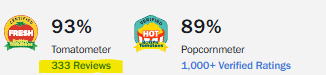 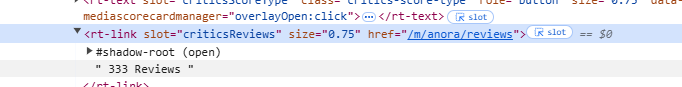

In [218]:
page = get(link_frame['url'][0])
content =BeautifulSoup(page.content, "html.parser")

I'm using the `slot` attribute to select the correct element here. Now I want to get the text and make the result into a single string. An easy way to do this is to just use the join method on a list:

In [219]:
reviewcount_tags = content.select('rt-link[slot="criticsReviews"]')
# this gives me a list, but I want a single string
reviewcount = [i.get_text().strip() for i in reviewcount_tags]
reviewcount

['333 Reviews']

In [220]:
reviewstring = ' '.join(reviewcount)
reviewstring

'333 Reviews'

This has a useful advantage of allowing me to get a single element even if my CSS selector ends up matching more than one thing on the page, but another way to accomplish this goal might be to just use some subsetting:

In [221]:
reviewcount[0]

'333 Reviews'

In any case, here's how I could write this whole expression as a one-liner:

In [222]:
' '.join([i.get_text().strip() for i in content.select('rt-link[slot="criticsReviews"]')])


'333 Reviews'

<b style="color:red;">
Question 2: using the parsed content from question 1, create a dictionary that matches the structure below (the values don't have to match, just the keys and value types)
</b>


>Hint: if you're finding that an expression matches multiple elements when you only want one, consider writing a more specific selector expression. One way to do this is by looking only elements that are nested inside of another element.
>For instance, `media-scorecard rt-text[slot="audienceScore"]` only retrieves `rt-text[slot="audienceScore"]` if it is inside of an element called `media-scorecard`. 

In [223]:
{'url': 'https://www.rottentomatoes.com/m/anora',
 'critics_score': '93%',
 'num_critic_reviews': '333 Reviews',
 'audience_score' : '89%',
 'num_audience_reviews': '1000+ Total reviews',
 'synopsis' : "Sean Baker's Palme d'Or winner ANORA is an audacious, thrilling, and comedic variation on a modern day Cinderella story. Mikey Madison (ONCE UPON A TIME IN HOLLYWOOD)..." # leaving out some text for brevity, but this should just have the synopsis.
}

{'url': 'https://www.rottentomatoes.com/m/anora',
 'critics_score': '93%',
 'num_critic_reviews': '333 Reviews',
 'audience_score': '89%',
 'num_audience_reviews': '1000+ Total reviews',
 'synopsis': "Sean Baker's Palme d'Or winner ANORA is an audacious, thrilling, and comedic variation on a modern day Cinderella story. Mikey Madison (ONCE UPON A TIME IN HOLLYWOOD)..."}

I've gone ahead and written code to extract the number of critic reviews and the audience score, you just need to find code for the rest and put them in a dictionary.

In [224]:
{   'url' : site,
    'num_critic_reviews' :' '.join([i.get_text().strip() for i in content.select('rt-link[slot="criticsReviews"]')]),
    'audience_score' :' '.join([i.get_text().strip() for i in content.select('media-scorecard rt-text[slot="audienceScore"]')])
}





{'url': 'https://www.rottentomatoes.com/m/anora',
 'num_critic_reviews': '333 Reviews',
 'audience_score': '89%'}

## Getting the data from multiple pages

Now we want to generalize from this case to get data from multiple pages. The first step is to write a function using the code from the previous questions. Then we'll use a loop to visit each link and apply that function to the HTML from each review page, and place the results in a data frame.

<b style="color:red;">
Question 3: Use the code you wrote in question 1 and 2 to define a function that takes a link as input and outputs a dictionary resembling the one you made in Q2
</b>


<b style="color:red;">

Question 4: Write a `for` loop to visit everything in `links_frame` and extract the relevant data. Then put your results in a DataFrame called `reviews_df`
</b>

> Be sure to include a brief pause between each iteration of your loop by using `time.sleep(.1)`

Although we didn't get the title from each result, we can now merge `reviews_df` and `links_frame` because both data frames should have a matching `url` column:

In [267]:
review_frame = reviews_df.merge(link_frame, on = 'url')

review_frame.head()
# note that you can access the .style attribute of the data frame to show the full text of the synoposis: 
# review_frame.head(3).style

,url,num_critic_reviews,num_audience_reviews,audience_score,critics_score,synopsis,title
0,https://www.rottentomatoes.com/m/anora,333 Reviews,"1,000+ Verified Ratings",89%,93%,Sean Baker's Palme d'Or winner ANORA is an aud...,Anora
1,https://www.rottentomatoes.com/m/mickey_17,92 Reviews,0 Verified Ratings,,86%,"Mickey 17, known as an ""expendable,"" goes on a...",Mickey 17
2,https://www.rottentomatoes.com/m/last_breath_2025,94 Reviews,500+ Verified Ratings,92%,79%,A heart-pounding film that follows seasoned de...,Last Breath
3,https://www.rottentomatoes.com/m/captain_ameri...,320 Reviews,"10,000+ Verified Ratings",79%,48%,Anthony Mackie returns as the high-flying hero...,Captain America: Brave New World
4,https://www.rottentomatoes.com/m/companion_2025,231 Reviews,"1,000+ Verified Ratings",89%,94%,"New Line Cinema--the studio that brought you ""...",Companion


## Using the data

Finally, we'll do some basic analysis of our results. I want to know which films critics like more than audiences. This should be as simple as subtracting `critics_score` - `audience_score`, but you'll notice that these are formatted as text rather than as numbers. I can use `to_numeric` to convert a string to a number, but I get an error if I try to do this because Pandas doesn't know how to handle the "%" in each string. 

An easy way to fix this is to use the `replace` method. To use replace, I'll need to write something like `x.replace('text to replace', 'text to replace it with'). So:


In [268]:
astring = "this is a string"
astring.replace("is a", "isn't a")


"this isn't a string"

You'll need to use `apply` or a list comprehension to make this work for the critics score:

In [269]:
review_frame['critics_score_numeric'] = pd.to_numeric(review_frame['critics_score'].apply(lambda x: x.replace('%', '')))


<b style="color:red;"> Question 5: create a new variable called `audience_score_numeric` that has a numeric value of the `audience_score` column. Then calculate the difference between the critics score compared to the audience score and identify the top 3 biggest disparities between audience and critic scores
</b>

# Saving our results

Once we're done, we might want to store this data for future analyses. An easy way to do that is to use `df.to_csv()` to write a data frame to a csv file. Then we can just use `pd.read.csv()` to re-load it later. 

In [271]:
review_frame.to_csv("movie_reviews.csv", index=False)


This will store `review_frame` in a csv file called "movie_reviews.csv". To read this data back in later, we would just run:

In [273]:
reviews_reloaded = pd.read_csv("movie_reviews.csv")
# check to make sure it worked: 
reviews_reloaded.head()

,url,num_critic_reviews,num_audience_reviews,audience_score,critics_score,synopsis,title,critics_score_numeric
0,https://www.rottentomatoes.com/m/anora,333 Reviews,"1,000+ Verified Ratings",89%,93%,Sean Baker's Palme d'Or winner ANORA is an aud...,Anora,93
1,https://www.rottentomatoes.com/m/mickey_17,92 Reviews,0 Verified Ratings,NaN,86%,"Mickey 17, known as an ""expendable,"" goes on a...",Mickey 17,86
2,https://www.rottentomatoes.com/m/last_breath_2025,94 Reviews,500+ Verified Ratings,92%,79%,A heart-pounding film that follows seasoned de...,Last Breath,79
3,https://www.rottentomatoes.com/m/captain_ameri...,320 Reviews,"10,000+ Verified Ratings",79%,48%,Anthony Mackie returns as the high-flying hero...,Captain America: Brave New World,48
4,https://www.rottentomatoes.com/m/companion_2025,231 Reviews,"1,000+ Verified Ratings",89%,94%,"New Line Cinema--the studio that brought you ""...",Companion,94
